In [4]:
import git
import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [6]:
#import daily covid cases per county
counties_df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
counties_df = counties_df[counties_df['state'].notna()] #drop rows where state is NaN value

#one hot encode states and add column to dataframe
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
states = np.array(counties_df['state']).reshape(-1, 1)
one_hot_encoder.fit(states)
states_encoded = one_hot_encoder.transform(states).toarray()

counties_df['states_encoded'] = states_encoded.tolist() #add column to dataframe

#convert date to datetime format
counties_df['date'] = pd.to_datetime(counties_df['date'])

In [7]:
counties_df.head()

,fips,date,county,state,cases,deaths,states_encoded
0,53061,2020-01-21,Snohomish,Washington,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,53061,2020-01-22,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,53061,2020-01-23,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,53061,2020-01-24,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,53061,2020-01-25,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
#preprocessing functions 

def minmax_scaler(x): 
    if max(x) == min(x):
        return x, min(x), max(x)
    else:
        scaled_x = (x - min(x))/(max(x) - min(x))
        return scaled_x, min(x), max(x)
    
def piecewise_log(arr):
    arr[arr == 0] = 1
    return np.log(arr)

In [52]:
split_point = 40 #for splitting into training and testing data

#initialize lists
inputs_total = []
conditions_total = []

train_inputs = []
train_targets = []
train_conditions = []

test_inputs = []
test_targets = []
test_conditions = []

fips = set(np.array(counties_df['fips'])) #list of unique fips
daterange = pd.date_range(min(counties_df['date']), max(counties_df['date'])).tolist() #range of dates 

fips_fewcases = [] #store fips of cases that are too few to model
fips_manycases = [] #store fips of cases that we are modeling with RNN


for i in fips: #iterate through counties 
    c_df = counties_df[counties_df['fips'] == i]
        
    if max(c_df['deaths']) <= 2:
        fips_fewcases.append(i)
    
    elif max(c_df['deaths']) > 2:
        
        x1 = np.zeros(len(daterange))
        x2 = np.zeros(len(daterange))

        c_daterange = c_df['date'].tolist()

        for j in range(len(daterange)): #populating time series data for each county
            if daterange[j] in c_daterange:
                x1[j] = c_df[c_df['date'] == daterange[j]]['cases'].values[0]
                x2[j] = c_df[c_df['date'] == daterange[j]]['deaths'].values[0]

        days = np.arange(0, len(x1))
        
        x = np.stack((piecewise_log(x1), piecewise_log(x2), days), axis = 1)
        
        x_train = x[:split_point]
        x_test = x[split_point:]
        
        
        inputs_total.append(x)
        
        p = counties_df[counties_df['fips'] == i]['states_encoded'].values[0]
        conditions_total.append(np.array(p))
        
        
        data_gen_train = TimeseriesGenerator(x_train, x_train,
                                       length=10, sampling_rate=1,
                                       batch_size=2)
        
        data_gen_test = TimeseriesGenerator(x_test, x_test,
                                       length=10, sampling_rate=1,
                                       batch_size=2)


        for k in range(len(data_gen_train)):
            x_b, y_b = data_gen_train[k]
            
            for l in range(len(x_b)):

                x_batch = x_b[l]
                y_batch = y_b[l]
                
                train_inputs.append(x_batch)
                train_targets.append([y_batch])

                #conditions   
                train_conditions.append(np.array(p))
                
        for k in range(len(data_gen_test)):
            x_b, y_b = data_gen_test[k]
            
            for l in range(len(x_b)):

                x_batch = x_b[l]
                y_batch = y_b[l]
                
                test_inputs.append(x_batch)
                test_targets.append([y_batch])

                #conditions   
                test_conditions.append(np.array(p))

test_inputs = np.array(test_inputs)
test_targets = np.array(test_targets)
test_conditions = np.array(test_conditions)


train_inputs = np.array(train_inputs)
train_targets = np.array(train_targets)
train_conditions = np.array(train_conditions)

In [53]:
inputs_total = np.array(inputs_total)
targets_total = np.array(targets_total)
conditions_total = np.array(conditions_total)

In [54]:
print(train_inputs.shape)
print(train_targets.shape)
print(train_conditions.shape)

(10770, 10, 3)
(10770, 1, 3)
(10770, 52)


In [55]:
print(test_inputs.shape)
print(test_targets.shape)
print(test_conditions.shape)

(15796, 10, 3)
(15796, 1, 3)
(15796, 52)


In [138]:
def inverse_minmax(scaled_x, min_x, max_x):
    if max(x) == min(x):
        return x, min(x), max(x)
    else:
        unscaled_x = scaled_x * (max_x - min_x) + min_x
        return unscaled_x, min_x, max_x

In [107]:
from cond_rnn import ConditionalRNN

class MySimpleModel(tf.keras.Model):
    def __init__(self):
        super(MySimpleModel, self).__init__() #allows you to inherit methods from tf.keras.Model I think
        self.cond = ConditionalRNN(20, cell='LSTM', dtype=tf.float32, return_sequences=True)
        self.cond2 = ConditionalRNN(12, cell='LSTM', dtype=tf.float32, return_sequences=True)
        self.cond3 = ConditionalRNN(1, cell='LSTM', dtype=tf.float32, return_sequences=True)
    
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs, **kwargs):
        x, cond = inputs
        o = self.cond([x, cond])
        o = self.cond2([o, cond])
        o = self.cond3([o, cond])
        o = self.out(o)
        return o

model = MySimpleModel()

# Define (real) data.


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.call([train_inputs, train_conditions])
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(x=[train_inputs, train_conditions], y= train_targets, 
                    validation_data=([test_inputs, test_conditions], test_targets), epochs=20)




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

ValueError: Input arrays should have the same number of samples as target arrays. Found 359 input samples and 0 target samples.

In [108]:
print('Evaluating model:')
model.evaluate([train_inputs, train_conditions], train_targets)

Evaluating model:
10770/10770 [==============================] - 3s 253us/sample - loss: 150.0390


150.03898303245325

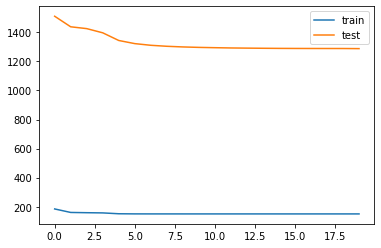

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [106]:
y = model.predict([train_inputs, train_conditions])
print(train_inputs.shape)
print(y.shape)
print(train_targets.shape)

(10770, 10, 3)
(10770, 10, 1)
(10770, 1, 3)


In [84]:
inputs_total.shape

(359, 94, 3)

In [ ]:
def generate_predictions(model, inputs, conditions, T):
    inputs = inputs
    prediction = model.predict([inputs, conditions])
    print('Generating predictions:')
    for i in range(T):
        y_predict = model.predict([inputs, conditions])
        inputs = numpy.append(inputs, [y_predict], axis = 0)
        prediction = numpy.append(prediction, [y_predict], axis = 0)
        
    return inputs, prediction
        
        
    

In [234]:
targets_total.shape

(201, 79)

Prediction:


C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


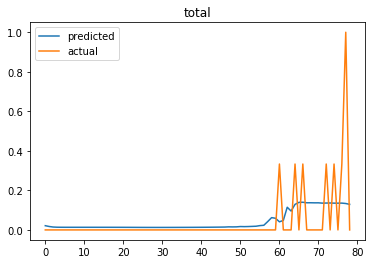

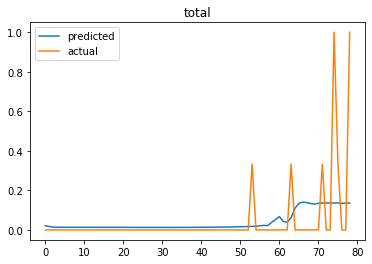

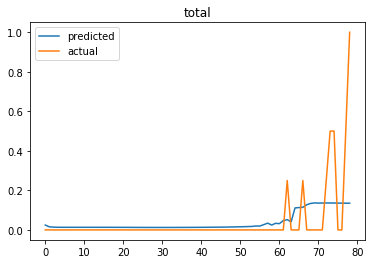

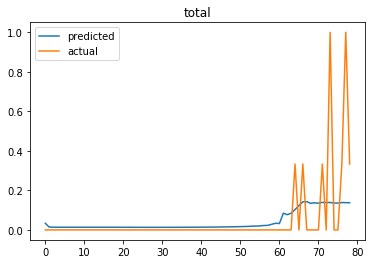

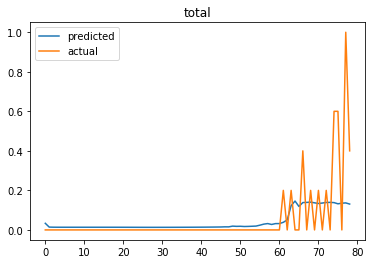

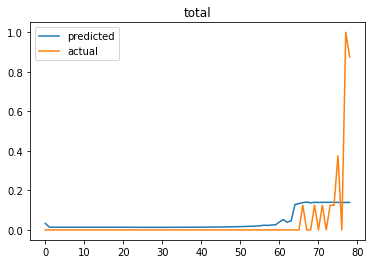

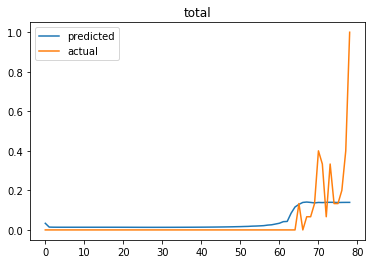

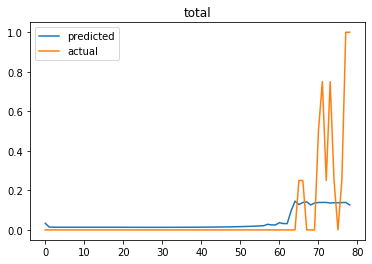

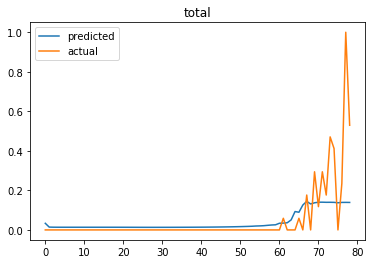

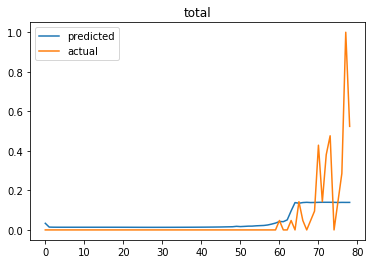

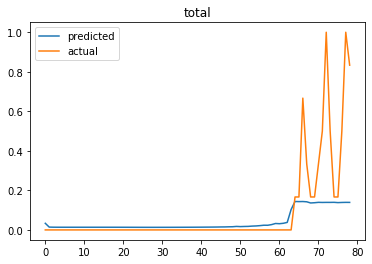

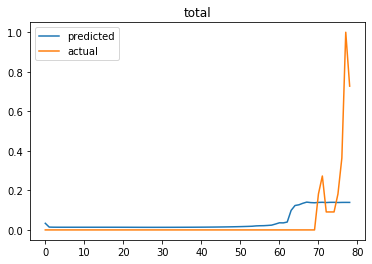

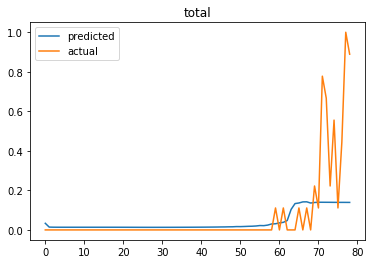

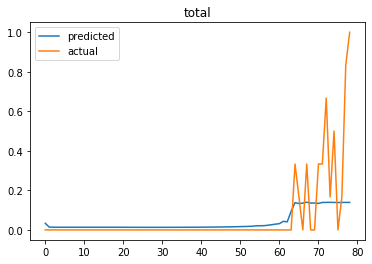

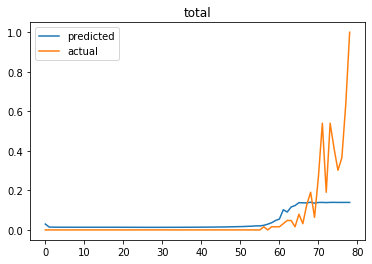

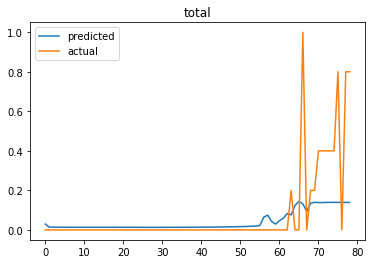

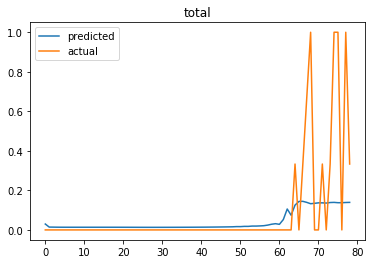

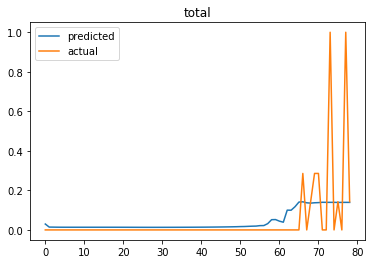

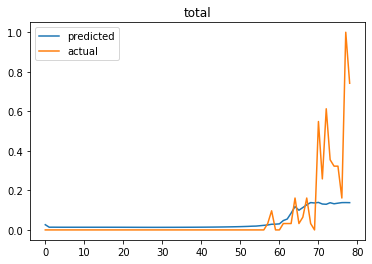

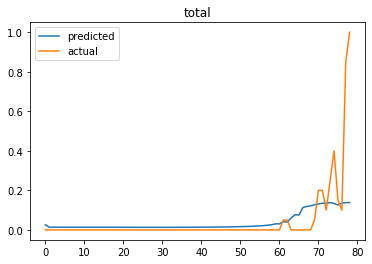

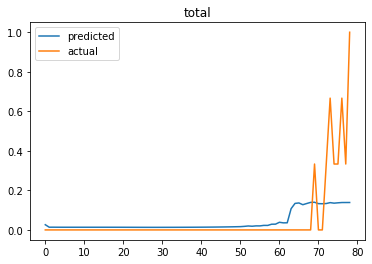

<Figure size 432x288 with 0 Axes>

In [238]:
print('Prediction:')
y_predict = model.predict([inputs_total, conditions_total])

for i in range(0, 21):
    plt.plot(y_predict[i][:, 0], label = 'predicted')
    plt.plot(targets_total[i], label = 'actual')
    plt.legend()
    plt.title('total')
    plt.figure()

Prediction:


C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


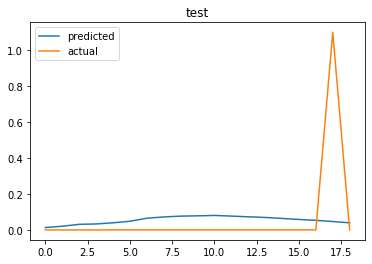

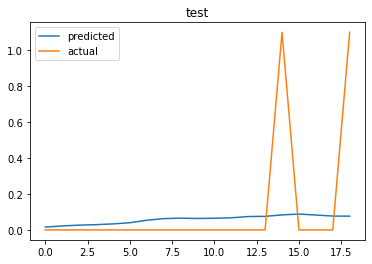

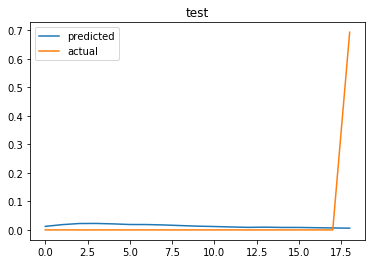

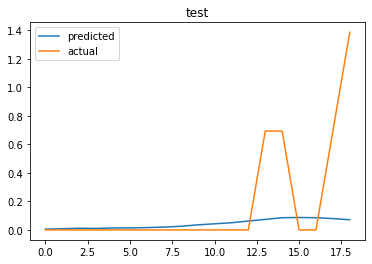

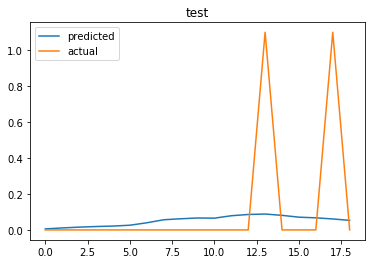

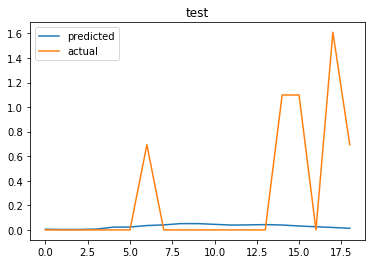

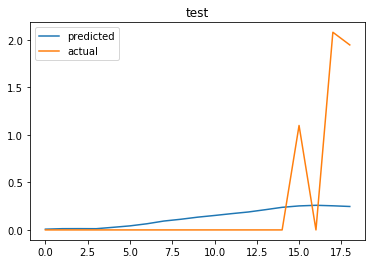

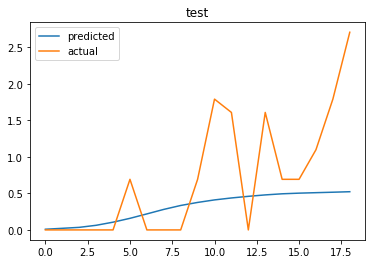

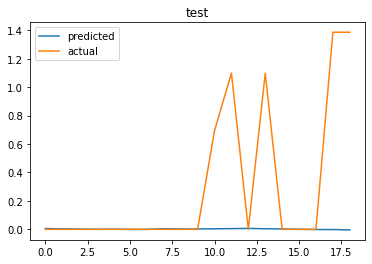

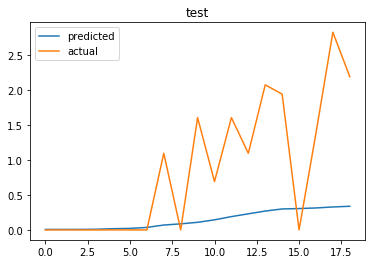

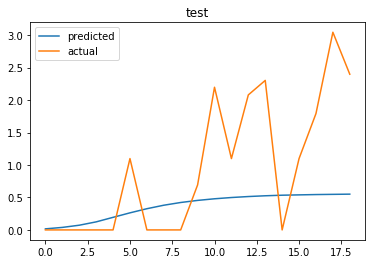

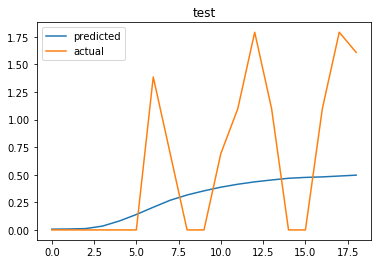

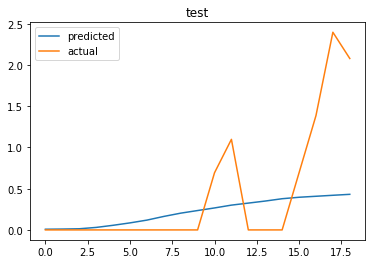

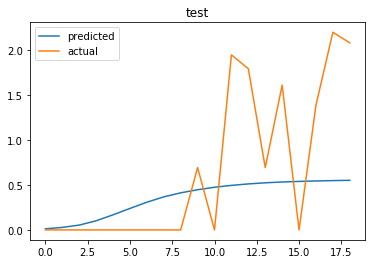

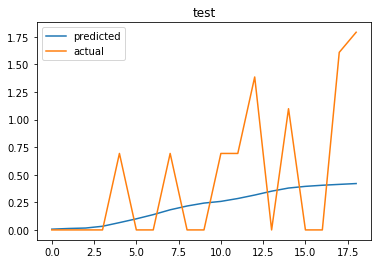

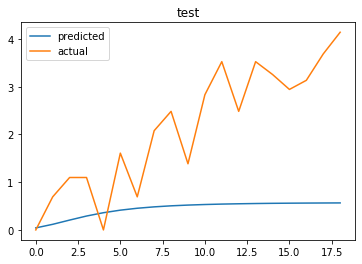

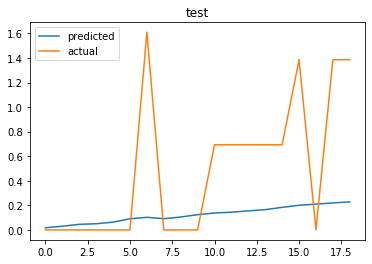

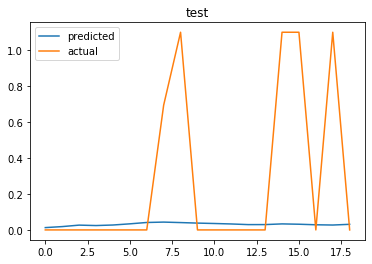

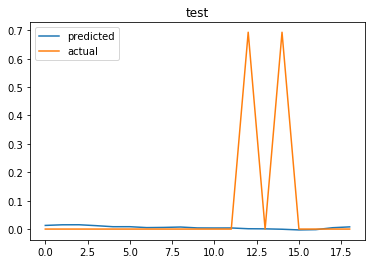

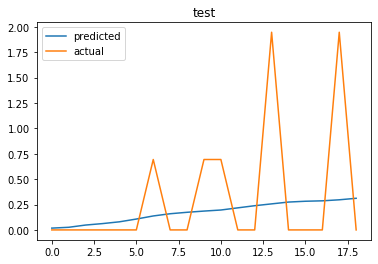

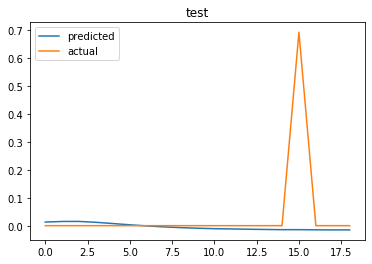

<Figure size 432x288 with 0 Axes>

In [168]:
print('Prediction:')
y_predict = model.predict([test_inputs, test_conditions])

for i in range(0, 21):
    plt.plot(y_predict[i], label = 'predicted')
    plt.plot(test_targets[i], label = 'actual')
    plt.legend()
    plt.title('test')
    plt.figure()